# Partie I. Randonnée

* **Q1/** Nombre de participants nés entre 1999 et 2003 inclus
```sql
SELECT COUNT(*) FROM Participant
WHERE ne>= 1998 AND ne<= 2004
```
* **Q2/** La durée moyenne des randonnées pour chaque niveau de difficulté.
```sql
SELECT diff,AVG(duree) FROM Rando
GROUP BY diff
```
* **Q3/** Le nom des participants pour lesquels la randonnée n°42 est trop difficile.
 * avec un produit cartésien :
 ```sql
    SELECT pnom FROM Participant,Rando
    WHERE rid = 42 AND diff_max < diff
 ```
  * avec une sous-requête :
  ```sql
    SELECT pnom FROM Participant
    WHERE diff_max < (SELECT diff FROM Rando
    WHERE rid=42)
   ```
* **Q4/** Les clés primaires des randonnées qui ont un ou des homonymes (nom identique et clé primaire distincte), sans redondance.
```sql
SELECT DISTINCT R1.rid FROM Rando AS R1
JOIN Rando AS R2
WHERE R1.rnom=R2.rnom
AND R1.rid <> R2.rid
```

* **Q5/** Importation du ﬁchier csv :

In [3]:
def importe_rando(nom_fichier) :
    """ nom_fichier est une chaîne de caractères
    La fonction renvoie une liste de listes contenant [lat,long,altitude,temps]"""
    f=open(nom_fichier,"r")
    f.readline() # on passe la première ligne (on la lit sans la stocker)
    lignes=f.readlines()
    f.close()
    coords = []
    for ligne in lignes :
        liste_valeurs=ligne.split(",")  # on reprend chaque ligne que l'on sépare
        liste_valeurs=[float(val) for val in liste_valeurs]
          # on écrase/remplace la ligne par la liste des valeurs, \n a été enlevé par float()
        coords.append(liste_valeurs)
    return coords

In [4]:
coords=importe_rando("suivi_rando.csv")
print(coords)

[[45.461516, 6.44461, 1315.221, 1597496965.0], [45.461448, 6.444426, 1315.702, 1597496980.0], [45.461383, 6.444239, 1316.182, 1597496995.0], [45.461641, 6.444035, 1316.663, 1597497010.0], [45.461534, 6.443879, 1317.144, 1597497025.0], [45.461595, 6.4437, 1317.634, 1597497040.0], [45.461562, 6.443521, 1318.105, 1597497055.0]]


* **Q6** Une recherche de maximum renvoie [lat, lon]

In [5]:
def plus_haut(coords) :
    """ coords est une liste de listes de flottants qui sont les caractéristiques d'un point
    La fonction lat et long du premier point le plus haut (s'il y en a plusieurs elle renvoie le premier lu)"""
    # A compléter
    maxi=coords[0][3] # on initialise avec la première altitude
    coordonnees=coords[0][0:2]
    for i in range(len(coords)) :
        if coords[i][3]>maxi :
            maxi=coords[i][3]
            coordonnees=coords[i][0:2]
    return coordonnees

* **Q7/** Calcul des dénivelés positifs et négatifs de la rondonnée

In [6]:
def deniveles(coords) :
    """ coords est une liste de listes de flottants qui sont les caractéristiques d'un point
    la fonciton renvoie les dénivelés cumulés positifs et négatifs"""
    # A compléter
    denivPos=0
    denivNeg=0
    for i in range(len(coords)-1) :
        deniv=coords[i+1][2]-coords[i][2]  # dénivelé entre deux points consécutifs
        if deniv>0 :
            denivPos+=deniv
        else :
            denivNeg+=deniv
    return [denivPos,denivNeg]    

* **Q8/** distance entre deux points

In [7]:
from math import asin,sin,cos,radians,sqrt

In [8]:
RT=6371 # rayon moyen volumétrique de la Terre en km

In [11]:
def distance(c1,c2) :
    """ c1 et c2 sont des données de points
    La fonction renvoie la distance entre ces points en tenant compte de la courbure
    de la Terre"""
    r=(c1[2]+c2[2])/2+RT*1e3
    p1,p2,l1,l2=radians(c1[0]),radians(c2[0]),radians(c1[1]),radians(c2[1])
    A=(sin((p2-p1)/2))**2
    B=cos(p1)*cos(p2)*(sin((l2-l1)/2))**2
    d = 2*r*asin(sqrt(A+B)) # formule de haversine
    dist = sqrt(d**2+(c2[2]-c1[2])**2) # théorème de Pythagore
    return dist


In [16]:
print("premier intervalle", distance(coords[0],coords[1]),"m")

premier intervalle 16.230964254992816 m


* **Q9/** distance totale de la randonnée

In [17]:
def distance_totale(coords) :
    """ coords est une liste de listes de flottant qui sont les caractéristiques de points
    La fonction renvoie la distance du parcours associé à coords"""
    # A compléter
    dist=0
    for i in range(len(coords)-1) :
        dist+=distance(coords[i],coords[i+1])
    return dist

In [18]:
print("distance parcourue", distance_totale(coords),"m")


distance parcourue 112.33798223373815 m


# Partie II. Mouvement brownien d'une petite particule

In [21]:
from math import pi  # on a déjà importé cos et sin
from random import uniform,gauss
# paramètres physiques
MU=0
SIGMA=1E-8
M=1E-6
ALPHA=1E-5
# vérification des hypothèses sur les paramètres
assert MU>=0 and SIGMA>0 and M>0 and ALPHA>0

* **Q10/** multiplication-addition vectorielle

In [22]:
def vma(v1,a,v2) :
    """ v1 et v2 sont des listes de 4 flottants associés à des vecteurs, a est un flottant
    La fonction renvoie v1+a*v2"""
    assert len(v1)==len(v2)
    res=[]
    for i in range(len(v1)) :
        res.append(v1[i]+a*v2[i])
    return res

* **Q11/** Projection de l'équation du mouvement sur (ox) :
$$\ddot{x}= -\dfrac{\alpha \dot{x}}{m}+ \dfrac{f_{B_x}}{m}$$
de même pour la projection sur (oy)

dérivée du vecteur d'état :

In [26]:
def derive(E) :
    """ E est une liste de 4 flottant (un vecteur d'état)
    La fonction renvoi la dérivée de E en utilisant l'edo donnée dans l'énoncé"""
    x,y,xp,yp = E
    theta = uniform(0,2*pi)
    norme = abs(gauss(MU,SIGMA))
    fBx = cos(theta)*norme # on projette fB sur (Ox)
    fBy = sin(theta)*norme # on projette fB sur (Oy)
    xpp = (-ALPHA*xp + fBx)/M
    ypp = (-ALPHA*yp + fBy)/M
    return [xp,yp,xpp,ypp]

* **Q12/** intégration par la méthode d'Euler

In [27]:
def euler(E0,dt,n) :
    """ E0 est une liste de 4 flottants (un vecteur d'état, dt est un flottant (le pas) et n un entier (le nombre de pas de la simulation
    La fonction renvoie une liste de vecteurs d'état obtenus en appliquant la méthode d'euler à l'edo proposée"""
    Es=[E0]
    # euler donne E_{k+1}=E_k + dt*derive(E_k)
    for k in range(n) :
        Es.append(vma(Es[k],dt,derive(Es[k])))
    return Es

In [28]:
# simulation
DT=0.002   # durée du pas en secondes
N=5000     # nombre de pas
Es=euler([0.0,0.0,0.0,0.0],DT,N)

**La partie ci-dessous est un test (juste pour vérifier)**

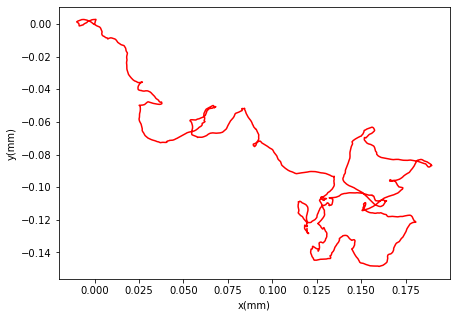

In [51]:
import matplotlib.pyplot as plt
Lx=[1e3*elem[0] for elem in Es]
Ly=[1e3*elem[1] for elem in Es]
plt.figure(figsize=(7,5))
plt.plot(Lx,Ly, "-r")
plt.xlabel("x(mm)")
plt.ylabel("y(mm)")
plt.show()

Le graphique obtenu n'est pas à la même échelle que celui de l'énoncé!

Peut être il a changé les constantes! 

# Partie III. Marche auto-évitante

* **Q13/** positions auto-évitantes suivantes possibles

In [32]:
from random import randrange,choice

In [33]:
def positions_possibles(p,atteints) :
    """ p est une liste de deux entiers (un point), atteints est une liste de points
    La fonction renvoie les déplacements possibles depuis p"""
    # avec la modélisation, recouper le chemin c'est passer par un point déjà exploré
    possibles=[]
    # A compléter
    voisins=[[p[0]-1,p[1]],[p[0]+1,p[1]],[p[0],p[1]-1],[p[0],p[1]+1]]
    for point in voisins :
        if not(point in atteints) :
            possibles.append(point)
    return possibles

* **Q14/** Il suﬃt de tourner en "escargot" : haut-droite-droite-bas-bas-gauche-haut, il y a une symétrie horizontale et 3 rotations de 90°. Cela fait 8 possibilités.


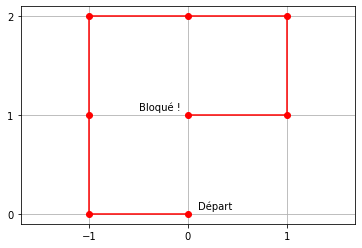

In [34]:
# visualisation (n'est pas demandé dans l'énoncé)
import matplotlib.pyplot as plt
chemin_x = [0,-1,-1,-1,0,1,1,0]
chemin_y = [0,0,1,2,2,2,1,1]
plt.plot(chemin_x,chemin_y,"o-r")
plt.axis("equal")
plt.grid("on")
plt.xticks([-1, 0, 1])
plt.yticks([0, 1, 2])
plt.text(0.1, 0.05, "Départ")
plt.text(-0.5, 1.05, "Bloqué !")
plt.show()

* **Q15/** 

In [36]:
def genere_chemin_naif(n) :
    """ n est un entier
    La fonction renvoie un chemin auto-évitant de longueur n"""
    chemin=[[0,0]]   # on part de l'origine
    # A compléter
    for i in range(n) :
        mvntsPossibles=positions_possibles(chemin[i],chemin)
        if mvntsPossibles==[] :
            return None
        chemin.append(choice(mvntsPossibles))
    return chemin

* **Q16/** 

In [37]:
N=100
#print("chemin",genere_chemin_naif(N))

**Complexité** :  la fonction `positions_possibles()` est en O(n) avec n la taille de atteints puisque l'on vérifie que les 4 voisins appartiennent à atteints.

A chaque itération, on appelle `positions_possibles()` dont le temps d'exécution est variable le reste est en temps constant (amorti pour `append()`). On fait donc de l'ordre de 1, puis 2 puis 3, puis 4 etc jusqu'à $n$ opérations à chaque itération. La complexité est comme la somme des entiers ($\sum^{n}_{k = 1} k$) elle est donc de $O(n^2)$

* **Q17/** Le graphique représente la proportion de chemin non aboutis de longueur n (n est l'abscisse et la proportion est l'ordonnée).
La proportion est calculée avec 10000 essais, le graphique montre que quand n augmente, la plupart du temps la méthode naïve n'aboutit pas.


* **Q18/** sorted implémente une variation du tri rapide dont la complexité est en $O(nlog(n))$. Le tri-fusion réalise un tri d'une liste de taille 𝑛 , dans le cas le pire, avec une complexité en $O(nlog(n))$. C'est la meilleure complexité possible dans le cas le pire.

* **Q19/** 

In [40]:
def est_CAE(chemin) :
    """ chemin est une liste de liste de deux flottants (des points)
    La fonction renvoie un booléen caractérisant le fait que le chemin est auto-evitant"""
    chemTrie=sorted(chemin)
    # la liste étant triée, s'il y a des doublons ils seront consécutifs
    for i in range(len(chemTrie)-1) :
        if chemTrie[i]==chemTrie[i+1] :
            return False
    return True

Si le chemin est de taille , le tri coûte $O(nlog(n))$ opérations, et la boucle coûte 𝑛 accès et tests d'égalité entre deux points, qui se font en $O(1)$ opérations.

La complexité dans le pire des cas de la fonction précédente est bien en $O(nlog(n))$.

* **Q20/** 

In [41]:
def rot(p,q,a) :
    """ p et q sont des listes de 2 entiers (des points), à est O, 1 ou 2
    La fonction renvoie les coordonnées de la rotation de q autour de p,
    l'angle vaut pi si A=0, pi/2 si a=1, -pi/2 si a=2"""
    # en travaillant sur le vecteur pq on trouve
    if a==0 :
        nouvQ=[2*p[0]-q[0],2*p[1]-q[1]]
    elif a==1 :
        nouvQ=[p[0]+p[1]-q[1],p[1]-p[0]+q[0]]
    else :
        nouvQ=[p[0]-p[1]+q[1],p[0]+p[1]-q[0]]
    return nouvQ

In [42]:
print(rot([1,0],[5,0],1))

[1, 4]


* **Q21/** 

In [43]:
def rotation(chemin,i_pivot,a) :
    """chemin est une liste de liste de deux flottants (des points), i_pivot est un entier indice
    de chemin, a est un entier 0, 1 ou 2
    La fonction renvoie le chemin dont les points après i_pivot ont subi une rotation
    a codée comme précédemment"""
    nouvChem=chemin[:i_pivot+1]
    for i in range(i_pivot+1,len(chemin)) :
        nouvChem.append(rot(chemin[i_pivot],chemin[i],a))
    return nouvChem

* **Q22/** 

In [44]:
from random import randrange

In [46]:
def genere_chemin_pivot(n,n_rot) :
    """ n et n_rot sont des entiers
    La fonction renvoie un chemin de longueur n en appliquant n_rot rotations
    """
    chem=[[k,0] for k in range(n)]   # génération d'une chemin initial
    k=0
    while k<n :
        i_piv=randrange(1,n)
        a=randrange(0,3)
        chemTemp=rotation(chem,i_piv,a)
        if est_CAE(chemTemp) :
            chem=chemTemp
            k+=1
    return chem

* **Q23/** 

In [53]:
N,A=1000,2.3
#print("chemin",genere_chemin_pivot(N,int(A*N)))

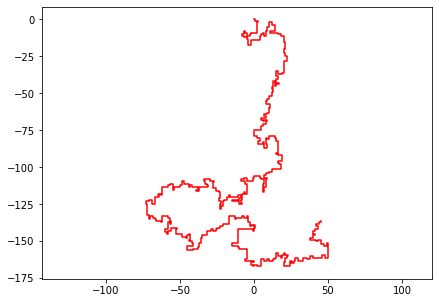

In [55]:
# visualisation (n'est pas demandé dans l'énoncé)
monChemin=genere_chemin_pivot(N,int(A*N))
Lx=[point[0] for point in monChemin]
Ly=[point[1] for point in monChemin]
plt.figure(figsize=(7, 5))
plt.plot(Lx,Ly, "-r")
plt.axis("equal")
plt.show()

L'organisation des trois points permet de savoir si une des rotations n'est pas pertinente auquel cas il est inutile de l'explorer. On peut donc ne travailler que sur deux valeurs de a.

Soient $A$, $B$ et $C$ respectivement, le pivot, le précédent et le suivant. Le produit vectoriel $AC*AB$ donne l'alignement ou l'orientation de l'angle (AC,AB). On calcule donc le déterminant avec $A_{pivot}(x0,y0)$, $B_{précédent}(x1,y1)$ et $C_{suivant}(x2,y2)$, on calcule $(x2-x0)*(y1-y0)-(x1-x0)*(y2-y0)$.

* si il est nul on  ne prend pas $\pi$
* si il est positif (il vaudra 1) on ne prend pas $\pi/2$
* si il est négatif (il vaudra -1) on ne prend pas $-\pi/2$

Il faut alors changer `a=randrange(0,3)` par le calcul du déterminant puis la suite de test avec une fonction `choice()` du module `random` sur une liste de deux valeurs. Soit le code suivant (par exemple) :
```python
from random import choice
i_piv = ranrange(1,n) # déjà écrit
A_piv=chemin[i_piv]
B_prec=chemin[i_piv-1]
C_suiv=chemin[i_piv+1]
det=(C_suiv[0]-A_piv[0])*(B_prec[1]-A_piv[1])-(B_prec[0]-A_piv[0])*(C_suiv[1]-A_piv[1])
if det==0:
    a=choice([1,2])
elif det>0:
    a=choice([0,2])
else:
    a=choice([0,1])
chemin_piv = rotation(chemin,i_piv,a) # déjà écrit
```